In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_C.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_C'], dtype=object)

In [6]:
data_std.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_C'] 
X = data_std.drop(['Coeff_C','Name'], axis=1)

### Using CV technique

RF
R2:  0.9008372673747731
RMSE:  0.31490114738632957
---------------------------------------
GB
R2:  0.89060482901605
RMSE:  0.3307494081384728
---------------------------------------
LR
R2:  0.7898220185602088
RMSE:  0.45845172203820017
---------------------------------------
RR
R2:  0.7901013674712555
RMSE:  0.4581469551669469
---------------------------------------
LASSO
R2:  0.8201449410831614
RMSE:  0.4240932196072446
---------------------------------------
gpr1
R2:  0.8092133199681941
RMSE:  0.4367913461045284
---------------------------------------
gpr2
R2:  0.9154324101386038
RMSE:  0.29080507193203536
---------------------------------------
gpr3
R2:  0.8368220791771456
RMSE:  0.4039528695564056
---------------------------------------
gpr4
R2:  0.8368220175732745
RMSE:  0.4039529458077085
---------------------------------------
gpr5
R2:  0.9155234977411864
RMSE:  0.2906484169212239
---------------------------------------
gpr6
R2:  0.9152786547559038
RMSE:  0.29106931347034204


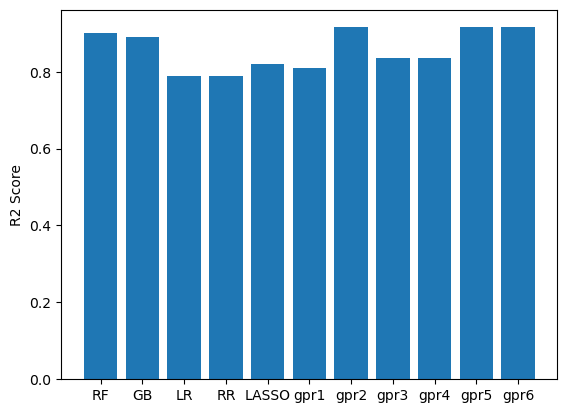

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  368.385508
4   mean_X2X  150.127121
2   mean_A2X   99.679846
9      E_coh   44.870201
6    std_A2X   17.303038
7    std_B2X   10.212695
11        OF    4.883700
0    density    4.063805
5    std_A2B    2.834262
10        TF    2.337026
8    std_X2X    1.479729
3   mean_B2X    0.423421


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9015021045140341
RMSE:  0.3138437437419549
---------------------------------------
GB
R2:  0.90651995520002
RMSE:  0.3057450650459954
---------------------------------------
LR
R2:  0.7898220185602087
RMSE:  0.4584517220382002
---------------------------------------
RR
R2:  0.7901013674712556
RMSE:  0.4581469551669469
---------------------------------------
LASSO
R2:  0.8200693592455341
RMSE:  0.4241823201813884
---------------------------------------
gpr1
R2:  0.8092133199691671
RMSE:  0.43679134610341463
---------------------------------------
gpr2
R2:  0.9154324101386029
RMSE:  0.2908050719320369
---------------------------------------
gpr3
R2:  0.7769709650260974
RMSE:  0.4722594996121333
---------------------------------------
gpr4
R2:  0.836822017573265
RMSE:  0.40395294580772023
---------------------------------------
gpr5
R2:  0.9155234977422831
RMSE:  0.2906484169193371
---------------------------------------
gpr6
R2:  0.9152786547559039
RMSE:  0.29106931347034193
--

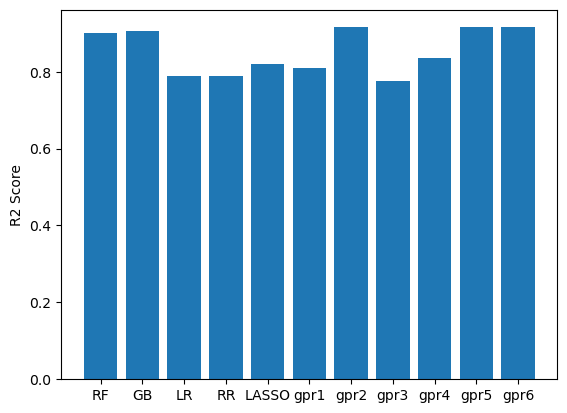

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9015021045140341
RMSE:  0.3138437437419549
---------------------------------------
GB
R2:  0.8935693011005095
RMSE:  0.3262371819696377
---------------------------------------
LR
R2:  0.7898220185602087
RMSE:  0.4584517220382002
---------------------------------------
RR
R2:  0.7901013674712556
RMSE:  0.4581469551669469
---------------------------------------
LASSO
R2:  0.8200693592455341
RMSE:  0.4241823201813884
---------------------------------------
gpr1
R2:  0.8092133199691671
RMSE:  0.43679134610341463
---------------------------------------
gpr2
R2:  0.9154324101386029
RMSE:  0.2908050719320369
---------------------------------------
gpr3
R2:  0.7928483293981816
RMSE:  0.45513917717750724
---------------------------------------
gpr4
R2:  0.836822017573265
RMSE:  0.40395294580772023
---------------------------------------
gpr5
R2:  0.9155234977422831
RMSE:  0.2906484169193371
---------------------------------------
gpr6
R2:  0.9152786547559039
RMSE:  0.29106931347034193

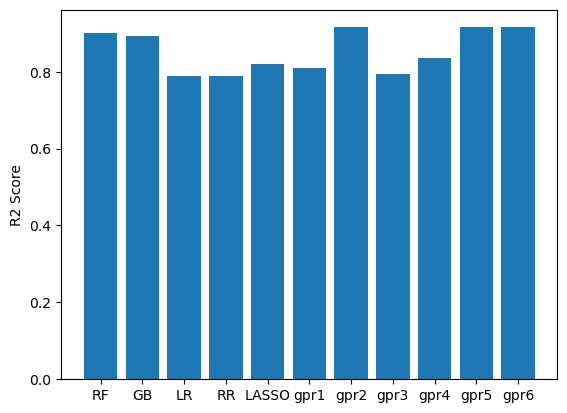

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9015021045140341
RMSE:  0.3138437437419549
---------------------------------------
GB
R2:  0.8860861551379229
RMSE:  0.33751125145997296
---------------------------------------
LR
R2:  0.7898220185602087
RMSE:  0.4584517220382002
---------------------------------------
RR
R2:  0.7901013674712556
RMSE:  0.4581469551669469
---------------------------------------
LASSO
R2:  0.8200693592455341
RMSE:  0.4241823201813884
---------------------------------------
gpr1
R2:  0.8092133199691671
RMSE:  0.43679134610341463
---------------------------------------
gpr2
R2:  0.9154324101386029
RMSE:  0.2908050719320369
---------------------------------------
gpr3
R2:  0.7751779780012682
RMSE:  0.47415400662520163
---------------------------------------
gpr4
R2:  0.836822017573265
RMSE:  0.40395294580772023
---------------------------------------
gpr5
R2:  0.9155234977422831
RMSE:  0.2906484169193371
---------------------------------------
gpr6
R2:  0.9152786547559039
RMSE:  0.2910693134703419

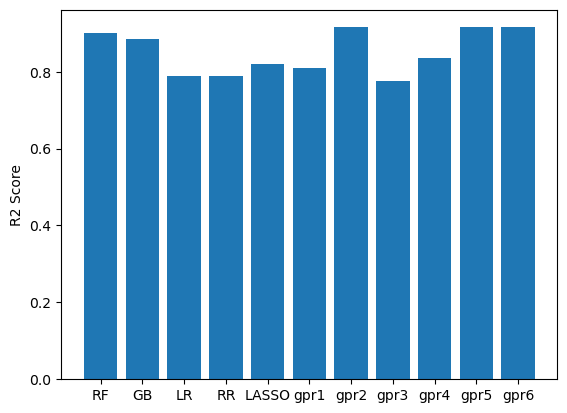

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.905712910575318
RMSE:  0.3070620286272498
---------------------------------------
GB
R2:  0.8897104703863455
RMSE:  0.3320986745135464
---------------------------------------
LR
R2:  0.8158329933938084
RMSE:  0.4291468357173237
---------------------------------------
RR
R2:  0.8159411724870104
RMSE:  0.4290207774840161
---------------------------------------
LASSO
R2:  0.8238026660260844
RMSE:  0.41975866158295727
---------------------------------------
gpr1
R2:  0.8311102382674554
RMSE:  0.4109619954844299
---------------------------------------
gpr2
R2:  0.9226908320040171
RMSE:  0.2780452624951248
---------------------------------------
gpr3
R2:  0.7366835298981631
RMSE:  0.5131437129127053
---------------------------------------
gpr4
R2:  0.8387583146964415
RMSE:  0.40154910696396595
---------------------------------------
gpr5
R2:  0.9127567674920218
RMSE:  0.2953696540065993
---------------------------------------
gpr6
R2:  0.9158239255029844
RMSE:  0.29013113327772255


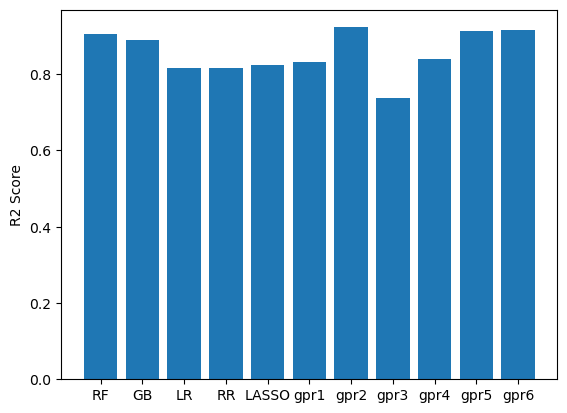

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_C.csv', encoding='cp1252')

In [24]:
data_mm.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_C'] 
X = data_mm.drop(['Coeff_C','Name'], axis=1)

### Using CV technique

RF
R2:  0.8956400093030108
RMSE:  0.07858447004095283
---------------------------------------
GB
R2:  0.8885640006287496
RMSE:  0.08120494358392318
---------------------------------------
LR
R2:  0.789822018560209
RMSE:  0.1115227117954698
---------------------------------------
RR
R2:  0.7963582591138108
RMSE:  0.10977491598335717
---------------------------------------
LASSO
R2:  0.807755776205331
RMSE:  0.10665871884282366
---------------------------------------
gpr1
R2:  0.7951790152782949
RMSE:  0.11009229818367844
---------------------------------------
gpr2
R2:  0.8614893065549909
RMSE:  0.09053392822766433
---------------------------------------
gpr3
R2:  -0.66347897458007
RMSE:  0.3137461251438382
---------------------------------------
gpr4
R2:  0.5451143335289127
RMSE:  0.1640668496556088
---------------------------------------
gpr5
R2:  0.9178242472341497
RMSE:  0.06973351524459892
---------------------------------------
gpr6
R2:  0.9169791594002239
RMSE:  0.070091164595906

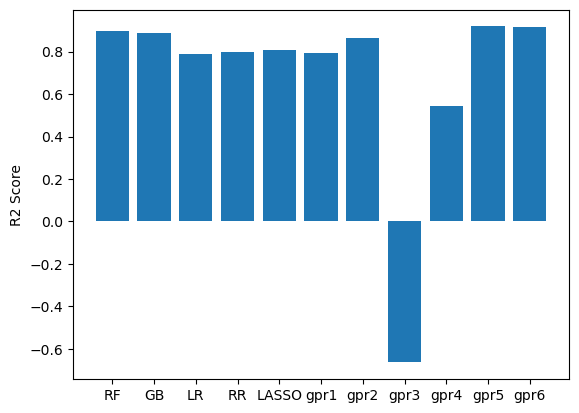

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  368.385508
4   mean_X2X  150.127121
2   mean_A2X   99.679846
9      E_coh   44.870201
6    std_A2X   17.303038
7    std_B2X   10.212695
11        OF    4.883700
0    density    4.063805
5    std_A2B    2.834262
10        TF    2.337026
8    std_X2X    1.479729
3   mean_B2X    0.423421


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8966996678529939
RMSE:  0.07818448356013297
---------------------------------------
GB
R2:  0.864618608462217
RMSE:  0.08950539216016336
---------------------------------------
LR
R2:  0.7898220185602086
RMSE:  0.1115227117954699
---------------------------------------
RR
R2:  0.7963582591138106
RMSE:  0.10977491598335722
---------------------------------------
LASSO
R2:  0.8077555264687271
RMSE:  0.10665878812078958
---------------------------------------
gpr1
R2:  0.7951790152783413
RMSE:  0.11009229818366598
---------------------------------------
gpr2
R2:  0.8614893065549946
RMSE:  0.09053392822766312
---------------------------------------
gpr3
R2:  0.5451143536947161
RMSE:  0.16406684601893687
---------------------------------------
gpr4
R2:  0.5451143194733297
RMSE:  0.16406685219037234
---------------------------------------
gpr5
R2:  0.9178242472341325
RMSE:  0.06973351524460622
---------------------------------------
gpr6
R2:  0.9169791594002238
RMSE:  0.07009116459

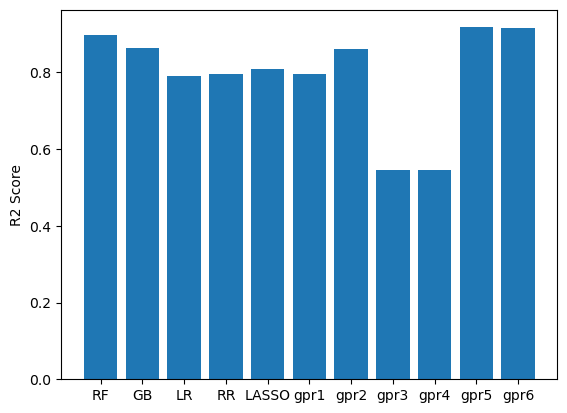

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8966996678529939
RMSE:  0.07818448356013297
---------------------------------------
GB
R2:  0.9103297750966803
RMSE:  0.07284400950486544
---------------------------------------
LR
R2:  0.7898220185602086
RMSE:  0.1115227117954699
---------------------------------------
RR
R2:  0.7963582591138106
RMSE:  0.10977491598335722
---------------------------------------
LASSO
R2:  0.8077555264687271
RMSE:  0.10665878812078958
---------------------------------------
gpr1
R2:  0.7951790152783413
RMSE:  0.11009229818366598
---------------------------------------
gpr2
R2:  0.8614893065549946
RMSE:  0.09053392822766312
---------------------------------------
gpr3
R2:  0.545114319795972
RMSE:  0.1640668521321875
---------------------------------------
gpr4
R2:  0.5451143194733297
RMSE:  0.16406685219037234
---------------------------------------
gpr5
R2:  0.9178242472341325
RMSE:  0.06973351524460622
---------------------------------------
gpr6
R2:  0.9169791594002238
RMSE:  0.070091164595

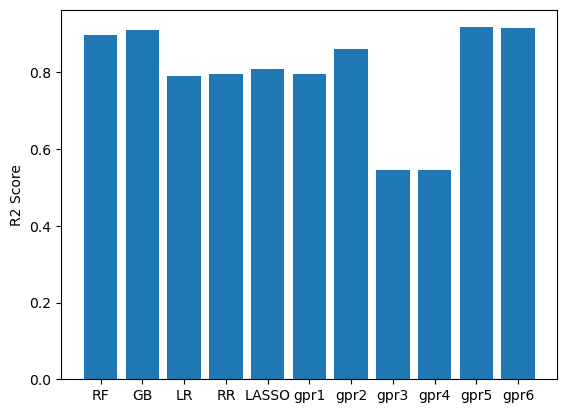

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF', 'std_X2X', 'mean_B2X'],
      dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8966996678529939
RMSE:  0.07818448356013297
---------------------------------------
GB
R2:  0.8918032034317189
RMSE:  0.08001601417852601
---------------------------------------
LR
R2:  0.7898220185602086
RMSE:  0.1115227117954699
---------------------------------------
RR
R2:  0.7963582591138106
RMSE:  0.10977491598335722
---------------------------------------
LASSO
R2:  0.8077555264687271
RMSE:  0.10665878812078958
---------------------------------------
gpr1
R2:  0.7951790152783413
RMSE:  0.11009229818366598
---------------------------------------
gpr2
R2:  0.8614893065549946
RMSE:  0.09053392822766312
---------------------------------------
gpr3
R2:  0.5451142200429446
RMSE:  0.16406687012150328
---------------------------------------
gpr4
R2:  0.5451143194733297
RMSE:  0.16406685219037234
---------------------------------------
gpr5
R2:  0.9178242472341325
RMSE:  0.06973351524460622
---------------------------------------
gpr6
R2:  0.9169791594002238
RMSE:  0.0700911645

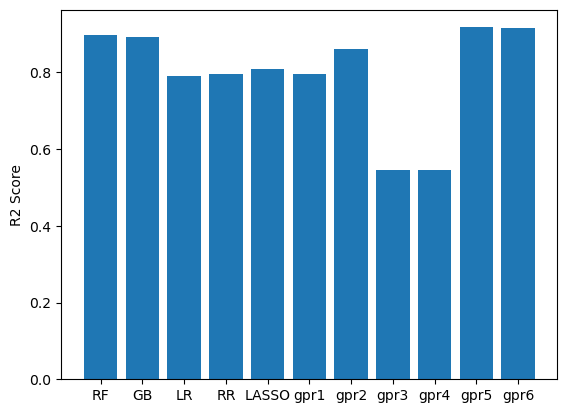

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'density', 'std_A2B', 'TF'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.902234641683476
RMSE:  0.07606103154032527
---------------------------------------
GB
R2:  0.9033579949658368
RMSE:  0.07562278698300898
---------------------------------------
LR
R2:  0.8158329933938083
RMSE:  0.1043940213919691
---------------------------------------
RR
R2:  0.8197140416827835
RMSE:  0.10328818933901586
---------------------------------------
LASSO
R2:  0.8077555264687271
RMSE:  0.10665878812078958
---------------------------------------
gpr1
R2:  0.8193871276507491
RMSE:  0.10338179359253392
---------------------------------------
gpr2
R2:  0.9079851656930341
RMSE:  0.0737901914383084
---------------------------------------
gpr3
R2:  -0.32972993276488927
RMSE:  0.28051199400848326
---------------------------------------
gpr4
R2:  0.6422108531418556
RMSE:  0.14550680146596384
---------------------------------------
gpr5
R2:  0.9192504679286577
RMSE:  0.06912572830372678
---------------------------------------
gpr6
R2:  0.9199002934339136
RMSE:  0.0688470245

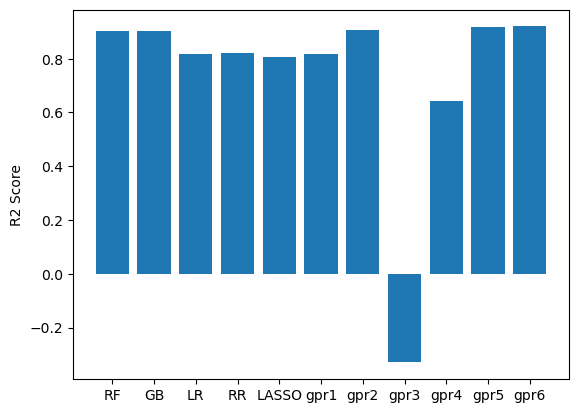

In [40]:
run_models()